# Volume 3: Metropolis Algorithm
    <Name>
    <Class>
    <Date>

In [63]:
# Import needed imports
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from math import sqrt, exp, log
import seaborn as sbn

## Problem 1

Write a function that uses the Metropolis Hastings algorithm to draw from the posterior distribution over the mean $\mu$ and variance $\sigma^2$. Use the given functions and Algorithm 1 to complete the problem.

Your function should return an array of draws, an array of the log probabilities, and an acceptance rate. 
Create plots resembling Figures 1 and 2:
 - Plot the log probabilities of the first 500 samples.
 - Plot the samples for $\mu$ in the order they were drawn, and likewise for $\sigma^2$.
 - Using `seaborn.kdeplot` plot the distribution of all samples for $\mu$, and likewise for $\sigma^2$.

Use $u=20$ for the parameter of the proposal function.
Use the initial state $\mathbf{y}_0=(\mu_0,\sigma^2_0)=(40,10)$.
Take 10,000 samples for both $\mu$ and $\sigma^2$. 

Compare your results with Figures 1 and 2.

In [64]:
def proposal(y, u):
    """Returns the proposal, i.e. a draw from Q(x,y) = N(x|y,uI)."""
    return stats.multivariate_normal.rvs(mean=y, cov=u*np.eye(len(y)))

In [65]:
def propLogDensity(x, muprior, sig2prior, scores):
    """Calculate the log of the proportional density funciton f."""
    if x[1] <= 0:
        return -np.inf
    logprob = muprior.logpdf(x[0]) + sig2prior.logpdf(x[1])
    logprob += stats.norm.logpdf(scores, loc=x[0], scale=np.sqrt(x[1])).sum()
    return logprob

In [66]:
def acceptance(x, y, muprior, sig2prior, scores):
    """
    Returns the acceptance probability of moving from y to x.
    """
    return np.exp(min(0, 
                  propLogDensity(x, muprior, sig2prior, scores) 
                - propLogDensity(y, muprior, sig2prior, scores)
    ))

In [67]:
def metropolis(y0, u, n_samples, muprior, sig2prior, scores):
    """
    Use the Metropolis algorithm to sample from posterior.
    Parameters:
        x0 ((2,) ndarray): The first entry is mu, the second entry is sigma^2.
        u (float): The standard deviation parameter for the proposal function.
        n_samples (int): The number of samples to generate.
        muprior, sig2prior (scipy.stats distributions): The prior distributions for mu and sigma^2.
        scores ((N,) ndarray): The array of exam scores
    
    Returns:
        draws ((n_samples, 2) ndarray): The MCMC samples.
        logprobs ((n_samples,) ndarray): The values of log f(y) of the samples.
        accept_rate (float): The proportion of accepted proposed samples.
    """
    
    # Initialize storage arrays
    Y = []
    log_probs = []
    acceptance_array = []
    
    # Iterate for n_samples
    for t in range(n_samples):
        
        # Get proposal 
        x = proposal(y0,u)
        # Get acceptance and see if result is accepted
        a = np.random.uniform(0,1)
        if a <= acceptance(x,y0,muprior,sig2prior, scores):
            y0 = x
            acceptance_array.append(0)
        else:
            acceptance_array.append(1)
        # Append draw and log probability
        Y.append(y0)
        log_prob = propLogDensity(x, muprior, sig2prior, scores)
        log_probs.append(log_prob)
        
    # Return desired values
    return np.array(Y), np.array(log_probs), np.sum(acceptance_array)/len(acceptance_array)

In [68]:
# Load in the data and initialize priors
scores = np.load("examscores.npy")

# Prior sigma^2 ~ IG(alpha, beta)
alpha = 3
beta = 50
sig2prior = stats.invgamma(alpha, scale=beta)

# Prior mu ~ N(m, s)
m = 80
s = 4
muprior = stats.norm(loc=m, scale=sqrt(s**2))

# Run Metropolis Algorithm
metro_1 = metropolis(np.array([40,10]), 20, 10000, muprior, sig2prior, scores)


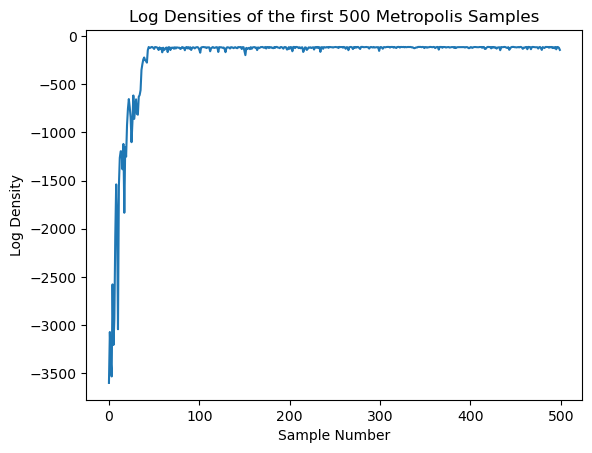

In [140]:
# Plot log densities of the first 500 Metropolis Samples
log_probs = metro_1[1][:500]
X = np.linspace(0,499,500)
plt.plot(X, log_probs)
plt.xlabel('Sample Number')
plt.ylabel('Log Density')
plt.title('Log Densities of the first 500 Metropolis Samples')
plt.show()

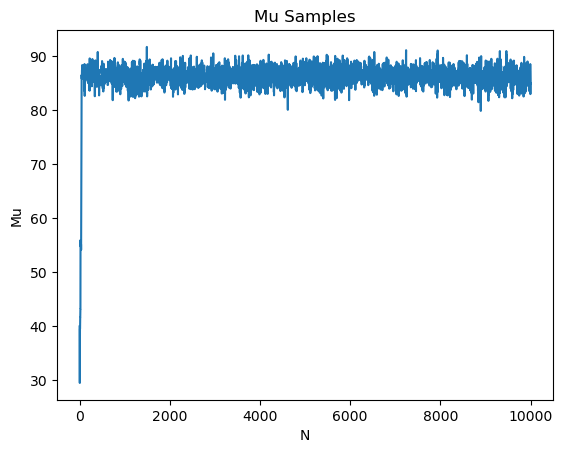

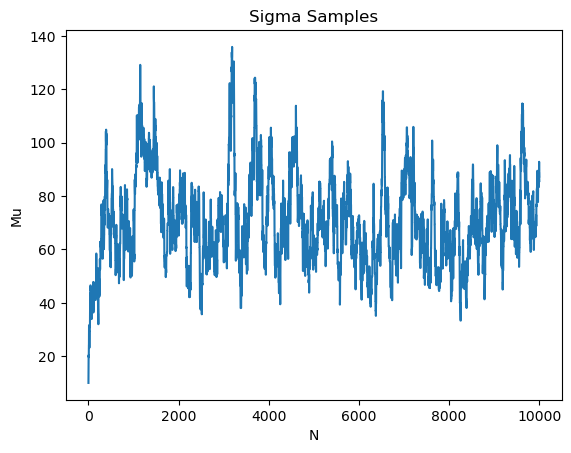

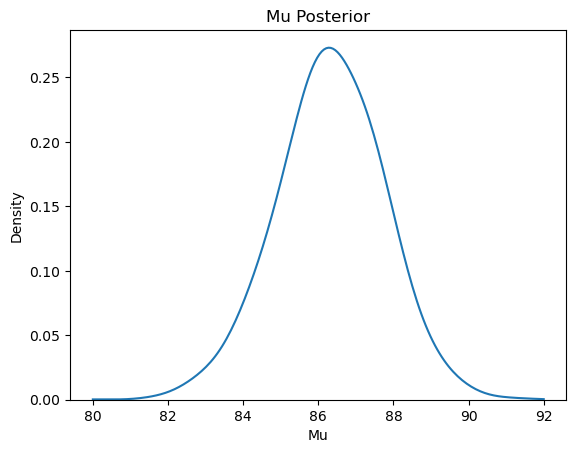

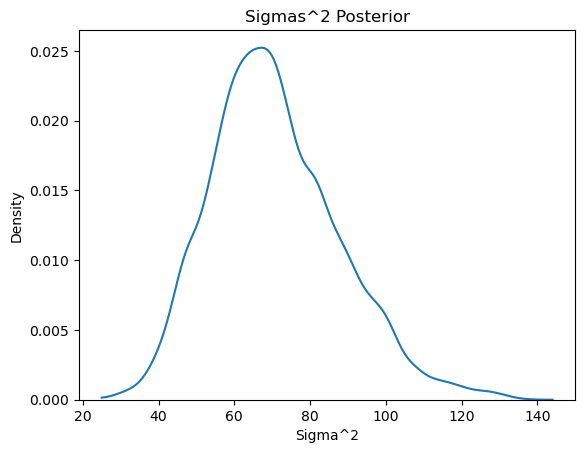

In [141]:
# Get mus and sigmas
mus, sigmas = metro_1[0][:,0], metro_1[0][:,1]

# Plot Mu Samples
X = np.linspace(0,len(mus)-1,len(mus))
plt.plot(X,mus)
plt.xlabel('N')
plt.ylabel('Mu')
plt.title('Mu Samples')
plt.show()

# Plot Sigma Samples
plt.plot(X,sigmas)
plt.xlabel('N')
plt.ylabel('Mu')
plt.title('Sigma Samples')
plt.show()

# Plot KDE of Mu
sbn.kdeplot(data = mus, clip = (80,92))
plt.xlabel('Mu')
plt.ylabel('Density')
plt.title('Mu Posterior')
plt.show()

# Plot KDE of Sigma
sbn.kdeplot(data = sigmas, clip = (25,200))
plt.xlabel('Sigma^2')
plt.ylabel('Density')
plt.title('Sigmas^2 Posterior')
plt.show()

## Problem 2

Write a function that accepts a spin configuration $\sigma$ for a lattice as a NumPy array.
Compute the energy $H(\sigma)$ of the spin configuration.
Be careful to not double count site pair interactions!

In [80]:
def random_lattice(n):
    """Construct a random spin configuration for an nxn lattice."""
    random_spin = np.zeros((n,n))
    for k in range(n):
        random_spin[k,:] = 2*np.random.binomial(1,.5, n) -1
    return random_spin

In [142]:
def lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    Parameter:
     L (ndarray): A lattice that we want the spin configuration for.
    
    Returns:
     (float): The spinfiguration of the lattice.
    """
    
    # Get the different spin combinations
    L_up = np.roll(L, 1, axis = 0)
    L_right = np.roll(L,1, axis = 1)
    
    # Sum them up to get lattice energy
    sum_1 = np.sum(L * L_right)
    sum_2 = np.sum(L * L_up)
    return sum_1 + sum_2

## Problem 3

Write a function that accepts an integer $n$ and chooses a pair of indices $(i,j)$ where $0 \le i,j \le n-1$.
Each possible pair should have an equal probability $\frac{1}{n^2}$ of being chosen.

In [98]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1.
    Parameter:
     n (int): 1/(n^2) probability for each location
     
    Returns:
     (index1, index2) (tuple): the tuple pair of the chosen indices. 
    """
    
    # Get random i,j
    i, j = np.random.randint(0,n-1), np.random.randint(0,n-1)
    return(i,j)

## Problem 4

Write a function that accepts a spin configuration $\sigma$, its energy $H(\sigma)$, and integer indices $i$ and $j$.
Compute the energy of the new spin configuration $\sigma^*$, which is $\sigma$ but with the spin flipped at the $(i,j)$ th entry of the corresponding lattice.
Do not explicitly construct the new lattice for $\sigma^*$.

In [99]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    
    Parameters:
     L (ndarray): the spin configuration 
     L_energy (float): the energy of the spin configuration.
     i (int): the first index.
     j (int): the second index.
    Returns:
     (float): the energy of the new updated lattice
    """

    # Get the energy change from the flip of sign
    sum = 2 * (L[i+1,j]+ L[i-1,j] + L[i,j+1] + L[i,j-1])*(L[i,j])
    # Add to energy already in configuration
    sum += L_energy
    return sum
    
    
    

## Problem 5

Write a function that accepts a float $\beta$ and spin configuration energies $H(\sigma)$ and $H(\sigma^*)$.
Calculate whether or not the new spin configuration $\sigma^*$ should be accepted (return `True` or `False`).

(Hint: np.random.binomial() might be useful function)

In [100]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration.
    
    Parameters:
     beta (float): a quantity inversly proportional to the temperature.
     energy_old (float): the energy of the old lattice.
     energy_new (float): the energy of the updated lattice.
     
    Returns:
     (boolean): whether the new energy should be accepted or not
    """
    
    # Return True if energy_new is less than energy_old
    if energy_new < energy_old:
        return True
    else:
        # Find probability of acceptance and get acceptance/rejection
        prob = np.exp(beta * (energy_old - energy_new))
        sample = np.random.binomial(1,prob)
        
        if sample == 1:
            return True
        else:
            return False
        

## Problem 6

Write a function that accepts a float $\beta>0$ and integers $n$, `n_samples`, and `burn_in`.
Initialize an $n\times n$ lattice for a spin configuration $\sigma$ using `random_lattice()`.
Use the Metropolis algorithm to (potentially) update the lattice `burn_in` times.
1. Use `flip_location()` to choose a site for possibly flipping the spin, thus defining a potential new configuration $\sigma^*$.
2. Use `updated_energy()` to calculate the energy $H(\sigma^*)$ of the proposed configuration.
3. Use `accept()` to accept or reject the proposed configuration. If it is accepted, set $\sigma = \sigma^*$ by flipping the spin at the indicated site.
4. Track $-\beta H(\sigma)$ at each iteration (independent of acceptance).

After the burn-in period, continue the iteration `n_samples` times, also recording every $100$th sample (to prevent memory failure).
Return the samples, the sequence of weighted energies $-\beta H(\sigma)$, and the acceptance rate.

Test your sampler on a $100 \times 100$ grid with $200000$ total iterations, with `n_samples` large enough so that you will keep $50$ samples, for $\beta = 0.2, 0.4, 1$.
Plot the proportional log probabilities, as well as a late sample from each test.


In [120]:
def ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """
    # Initialize lattice and tracker arrays
    L = random_lattice(n)
    spin_configs = []
    weighted_energies = []
    acceptances = []
    
    # Do a burn-in
    for burn in range(burn_in):
        # Get lattice energy
        old_energ = lattice_energy(L)
        
        # Track every hundreth state
        if burn % 100 == 0:
            spin_configs.append(L)
            weighted_energies.append(-1*beta*old_energ)
        
        # Flip location
        i_j = flip_location(n)
        i,j = i_j[0], i_j[1]
        
        # Potentially update energy if accepted
        updated_energ = updated_energy(L, old_energ, i,j)
        acc = accept(beta, old_energ, updated_energ)
        if acc == True:
            L[i,j] = -1 * L[i,j]
        
    # Now, it is for real sampling    
    for m in range(n_samples):
        # Get lattice energy
        old_energ = lattice_energy(L)
        
        # Track every hundreth state
        if m % 100 == 0:
            spin_configs.append(L)
            weighted_energies.append(-1*beta*old_energ)
        
        # Flip location
        i_j = flip_location(n)
        i,j = i_j[0], i_j[1]
        
        # Potentially update energy if accepted
        updated_energ = updated_energy(L, old_energ, i,j)
        acc = accept(beta, old_energ, updated_energ)
        
        # Append acceptances
        if acc == True:
            L[i,j] = -1 * L[i,j]
            acceptances.append(1)
        else:
            acceptances.append(0)
        
    # Return values
    return spin_configs, weighted_energies, np.sum(acceptances)/len(acceptances)
        
        
        
        

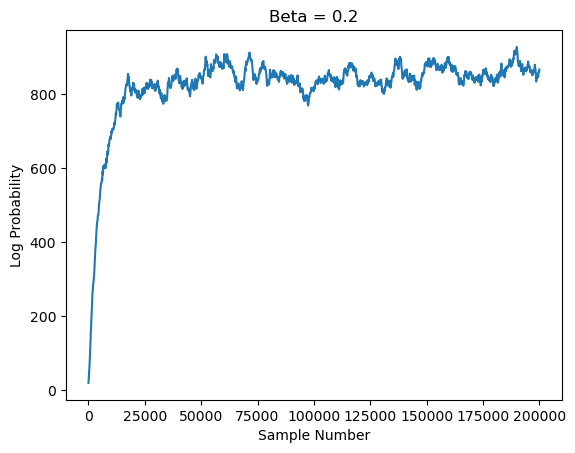

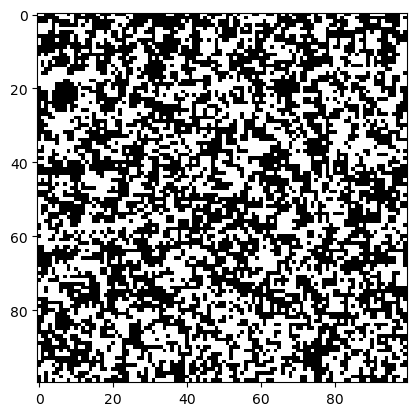

In [137]:
# Run Metropolis Algorithm for beta = 0.2
beta = 0.2
val = ising_metropolis(beta)

# Plot results
X = np.linspace(0,200000-1,2000)
log_probs1 = np.array(val[1]) * -1
plt.plot(X, log_probs1)
plt.xlabel('Sample Number')
plt.ylabel('Log Probability')
plt.title('Beta = 0.2')
plt.show()

# Plot spin configuration
spin_config = val[0][-1]
plt.imshow(spin_config, cmap= 'gray')

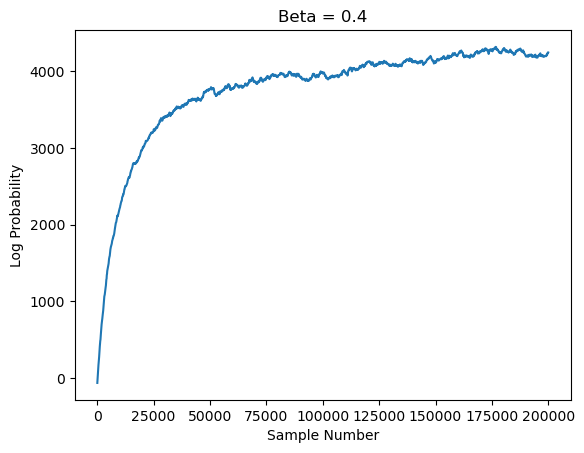

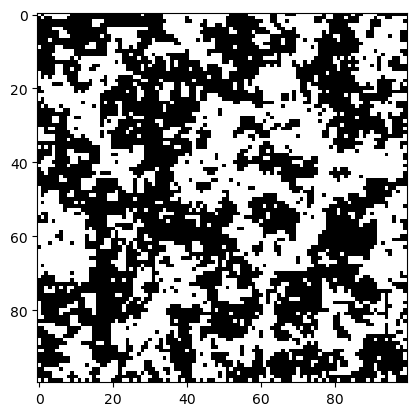

In [138]:
# Run Metropolis Algorithm for beta = 0.4
beta = 0.4
val = ising_metropolis(beta)

# Plot results
X = np.linspace(0,200000-1,2000)
log_probs1 = np.array(val[1]) * -1
plt.plot(X, log_probs1)
plt.xlabel('Sample Number')
plt.ylabel('Log Probability')
plt.title('Beta = 0.4')
plt.show()

# Plot spin configuration
spin_config = val[0][-1]
plt.imshow(spin_config, cmap= 'gray')

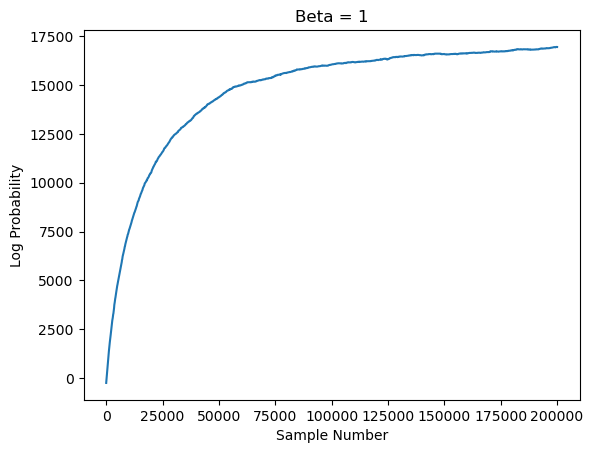

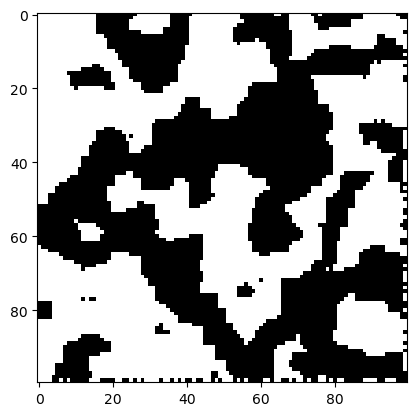

In [143]:
# Run Metropolis Algorithm for beta = 1
beta = 1
val = ising_metropolis(beta)

# Plot results
X = np.linspace(0,200000-1,2000)
log_probs1 = np.array(val[1]) * -1
plt.plot(X, log_probs1)
plt.xlabel('Sample Number')
plt.ylabel('Log Probability')
plt.title('Beta = 1')
plt.show()

# Plot spin configuration
spin_config = val[0][-1]
plt.imshow(spin_config, cmap= 'gray')